In [34]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import pywt 


SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

In [35]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1206.71it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [36]:
from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
ids_250 = df[df['frequencies'] == 250].index.tolist() # 65 signals are sampled using fs = 128
resampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
sampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_128):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:08<00:00,  7.61it/s]


In [37]:
#Preprocessing used in practical lessons
from scipy.signal import resample, butter, lfilter, iirnotch

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

#def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 55, signal_freq=128):
def bandpass_filter(data, filter_order=5, lowcut = 0.5, highcut = 30, signal_freq=250):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        powerline = 60
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data,zi = None)
        #b,a = notch_filter(powerline,signal_freq)
        #y = lfilter(b,a,y)
        return y


['N', 'N', 'N', 'N', 'S', 'N', 'S', 'N']


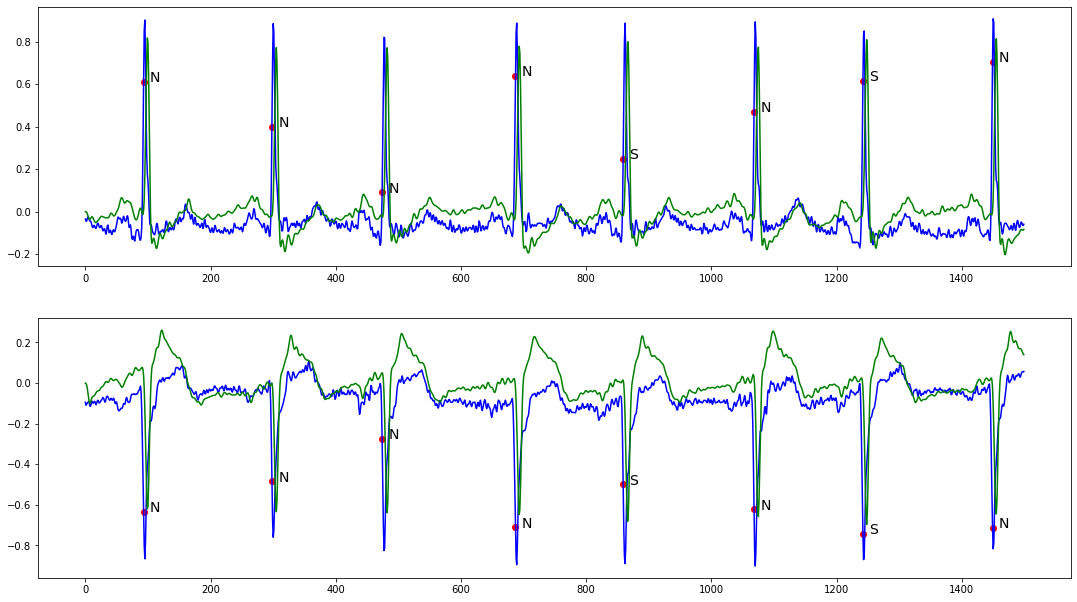

In [38]:
# plot signal 
from scipy.fft import fft, fftfreq

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    ax1.plot(x,first_lead,color='blue')
    ax2.plot(x,second_lead,color='blue')
    
    ax1.plot(x,bandpass_filter(first_lead),color='green')
    ax2.plot(x,bandpass_filter(second_lead),color='green')


    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()

plot_signal(df,1,1500)

In [59]:
filtered_df = df.copy(deep= True)

ids = filtered_df.index.tolist()

for id_ in tqdm(ids):
    
    row = filtered_df.iloc[id_]
    first = row['ecg_lead_1']
    second = row['ecg_lead_2']
    filtered_first = np.asarray(bandpass_filter(first))
    filtered_second =  np.asarray(bandpass_filter(second))

    filtered_df.iloc[id_]['ecg_lead_1'] = pd.Series(filtered_first)
    filtered_df.iloc[id_]['ecg_lead_2'] = pd.Series(filtered_second)
   


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:07<00:00, 13.54it/s]


In [62]:
# scale data in the filtered dataset in a 10 s time window 250*10 samples 

fs = 250
time_window = 10
samples = fs * time_window 

for id in tqdm(filtered_df.index.tolist()):
    row = filtered_df.loc[id]
    first_lead = row['ecg_lead_1']
    second_lead = row['ecg_lead_2']
    l_ = len(first_lead)
    scaled_1 = list()
    scaled_2 = list()
    
    for i in range(int(l_/samples)):
        to_scale_1 = first_lead[i*samples:i*samples+samples] 
        to_scale_2 = second_lead[i*samples:i*samples+samples]
        
        scaled_1 += list(hp.scale_data(to_scale_1,lower=0,upper=1))
        scaled_2 += list(hp.scale_data(to_scale_2,lower=0,upper=1))
    print(len(scaled_1))
    filtered_df.loc[id]['ecg_lead_1'] = scaled_1
    filtered_df.loc[id]['ecg_lead_2'] = scaled_2


  2%|█▌                                                                                | 2/105 [00:00<00:17,  5.90it/s]

450000
450000


  4%|███                                                                               | 4/105 [00:00<00:17,  5.82it/s]

450000
450000


  6%|████▋                                                                             | 6/105 [00:01<00:17,  5.68it/s]

450000
450000


  8%|██████▏                                                                           | 8/105 [00:01<00:17,  5.60it/s]

450000
450000


 10%|███████▋                                                                         | 10/105 [00:01<00:16,  5.63it/s]

450000
450000


 11%|█████████▎                                                                       | 12/105 [00:02<00:16,  5.61it/s]

450000
450000


 13%|██████████▊                                                                      | 14/105 [00:02<00:16,  5.64it/s]

450000
450000


 15%|████████████▎                                                                    | 16/105 [00:02<00:15,  5.82it/s]

450000
450000


 17%|█████████████▉                                                                   | 18/105 [00:03<00:15,  5.70it/s]

450000
450000


 19%|███████████████▍                                                                 | 20/105 [00:03<00:14,  5.74it/s]

450000
450000


 21%|████████████████▉                                                                | 22/105 [00:03<00:14,  5.70it/s]

450000
450000


 23%|██████████████████▌                                                              | 24/105 [00:04<00:14,  5.63it/s]

450000
450000


 25%|████████████████████                                                             | 26/105 [00:04<00:14,  5.63it/s]

450000
450000


 27%|█████████████████████▌                                                           | 28/105 [00:04<00:13,  5.70it/s]

450000
450000


 29%|███████████████████████▏                                                         | 30/105 [00:05<00:13,  5.71it/s]

450000
450000


 30%|████████████████████████▋                                                        | 32/105 [00:05<00:12,  5.71it/s]

450000
450000


 32%|██████████████████████████▏                                                      | 34/105 [00:05<00:12,  5.66it/s]

450000
450000


 34%|███████████████████████████▊                                                     | 36/105 [00:06<00:12,  5.57it/s]

450000
450000


 36%|█████████████████████████████▎                                                   | 38/105 [00:06<00:11,  5.68it/s]

450000
450000


 38%|██████████████████████████████▊                                                  | 40/105 [00:07<00:11,  5.56it/s]

450000
450000


 40%|████████████████████████████████▍                                                | 42/105 [00:07<00:11,  5.52it/s]

450000
450000


 42%|█████████████████████████████████▉                                               | 44/105 [00:07<00:10,  5.59it/s]

450000
450000


 44%|███████████████████████████████████▍                                             | 46/105 [00:08<00:10,  5.56it/s]

450000
450000


 46%|█████████████████████████████████████                                            | 48/105 [00:08<00:10,  5.55it/s]

450000
450000


 48%|██████████████████████████████████████▌                                          | 50/105 [00:08<00:10,  5.47it/s]

450000
450000


 50%|████████████████████████████████████████                                         | 52/105 [00:09<00:09,  5.30it/s]

450000
450000


 51%|█████████████████████████████████████████▋                                       | 54/105 [00:09<00:09,  5.48it/s]

450000
450000


 53%|███████████████████████████████████████████▏                                     | 56/105 [00:09<00:08,  5.46it/s]

450000
450000


 55%|████████████████████████████████████████████▋                                    | 58/105 [00:10<00:08,  5.47it/s]

450000
450000


 57%|██████████████████████████████████████████████▎                                  | 60/105 [00:10<00:08,  5.53it/s]

450000
450000


 58%|███████████████████████████████████████████████                                  | 61/105 [00:10<00:07,  5.60it/s]

450000


 61%|█████████████████████████████████████████████████▎                               | 64/105 [00:11<00:07,  5.26it/s]

450000
450000
450000


 63%|██████████████████████████████████████████████████▉                              | 66/105 [00:11<00:07,  5.49it/s]

450000
450000


 65%|████████████████████████████████████████████████████▍                            | 68/105 [00:12<00:06,  5.50it/s]

450000
450000


 66%|█████████████████████████████████████████████████████▏                           | 69/105 [00:12<00:06,  5.35it/s]

450000


 67%|██████████████████████████████████████████████████████                           | 70/105 [00:12<00:06,  5.22it/s]

450000


 68%|██████████████████████████████████████████████████████▊                          | 71/105 [00:12<00:06,  4.98it/s]

450000


 69%|███████████████████████████████████████████████████████▌                         | 72/105 [00:13<00:06,  4.87it/s]

450000


 70%|█████████████████████████████████████████████████████████                        | 74/105 [00:13<00:06,  5.01it/s]

450000
450000


 71%|█████████████████████████████████████████████████████████▊                       | 75/105 [00:13<00:05,  5.05it/s]

450000


 72%|██████████████████████████████████████████████████████████▋                      | 76/105 [00:13<00:05,  4.84it/s]

450000
450000


 75%|████████████████████████████████████████████████████████████▉                    | 79/105 [00:14<00:05,  4.96it/s]

450000
450000


 77%|██████████████████████████████████████████████████████████████▍                  | 81/105 [00:14<00:04,  5.16it/s]

450000
450000


 78%|███████████████████████████████████████████████████████████████▎                 | 82/105 [00:14<00:04,  5.29it/s]

450000


 79%|████████████████████████████████████████████████████████████████                 | 83/105 [00:15<00:04,  5.06it/s]

450000


 81%|█████████████████████████████████████████████████████████████████▌               | 85/105 [00:15<00:04,  4.97it/s]

450000
450000


 83%|███████████████████████████████████████████████████████████████████              | 87/105 [00:15<00:03,  5.27it/s]

450000
450000


 85%|████████████████████████████████████████████████████████████████████▋            | 89/105 [00:16<00:02,  5.48it/s]

450000
450000


 87%|██████████████████████████████████████████████████████████████████████▏          | 91/105 [00:16<00:02,  5.63it/s]

450000
450000


 89%|███████████████████████████████████████████████████████████████████████▋         | 93/105 [00:17<00:02,  5.58it/s]

450000
450000


 90%|█████████████████████████████████████████████████████████████████████████▎       | 95/105 [00:17<00:01,  5.72it/s]

450000
450000


 92%|██████████████████████████████████████████████████████████████████████████▊      | 97/105 [00:17<00:01,  5.72it/s]

450000
450000


 94%|████████████████████████████████████████████████████████████████████████████▎    | 99/105 [00:18<00:01,  5.70it/s]

450000
450000


 96%|████████████████████████████████████████████████████████████████████████████▉   | 101/105 [00:18<00:00,  5.66it/s]

450000
450000


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 103/105 [00:18<00:00,  5.71it/s]

450000
450000


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:19<00:00,  5.05it/s]

450000
450000


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:19<00:00,  5.46it/s]


In [63]:
signal_ids = filtered_df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()

  0%|                                                                                          | 0/105 [00:00<?, ?it/s]C:\Users\simon\AppData\Local\Temp/ipykernel_20848/1816920695.py:24: RuntimeWarning: Mean of empty slice.
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()
100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 375.82it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S114,"[228, 228, 224, 218, 222, 222, 222, 220, 226, ...",[],223.842278,NaN
S115,"[222, 230, 156, 230, 240, 148, 232, 216, 210, ...",[144],172.064542,144.000000
S116,"[244, 242, 226, 226, 216, 216, 208, 196, 222, ...",[146],227.509934,146.000000
S117,"[238, 248, 244, 242, 246, 232, 248, 246, 246, ...","[232, 194, 180, 196, 192, 180, 178, 178, 174, ...",197.463626,163.209964
S118,"[166, 164, 168, 158, 160, 166, 159, 162, 162, ...",[],183.494896,NaN


In [64]:
import heartpy as hp 

classes = np.array(["N","S","V"])

patch_length = 400

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df['sigId']
   
    for id in tqdm(ids):
        row = df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        
        avg_RR = RR_df.loc[sigId]['Avg_RR_distance'] # T for the signal 

        for i,peak in enumerate(peaks):
            stringIdx = str(sigId)+'_'+str(i)    
            dataset_dict[stringIdx] = {}
            dataset_dict[stringIdx]["first_lead"] = list()
            dataset_dict[stringIdx]["second_lead"] = list()
            
            size = list(range(int(peak-(patch_length/2)),int(peak+patch_length/2)))

            for s in size:
                if(s < 0 or s >= len(first_lead_signal)):
                    dataset_dict[stringIdx]["first_lead"].append(0.)
                    dataset_dict[stringIdx]["second_lead"].append(0.)
                else:
                    dataset_dict[stringIdx]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[stringIdx]["second_lead"].append(second_lead_signal[s])
            
            first_lead = dataset_dict[stringIdx]["first_lead"][:]
            second_lead = dataset_dict[stringIdx]["second_lead"][:]
            
            #dataset_dict[stringIdx]["first_lead"] = hp.enhance_peaks(first_lead, iterations=1)
            #dataset_dict[stringIdx]["second_lead"] = hp.enhance_peaks(first_lead, iterations=1)
            
            dataset_dict[stringIdx]["stringLabel"] = labels[i]
            dataset_dict[stringIdx]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df


In [65]:
validation_percentage = 0.2
training_df, validation_df = train_test_split(filtered_df,test_size = validation_percentage,random_state=SEED)

training_patches_df_ = create_patch_dataset(training_df)
validation_patches_df_ = create_patch_dataset(validation_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.82it/s]


In [66]:
training_patches_df_.head()

,first_lead,second_lead,stringLabel,label
S097_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S097_1,"[0.9580070239423568, 0.9044837476636258, 0.785...","[0.713288770919864, 0.8458495429006658, 0.9387...",N,"[1.0, 0.0, 0.0]"
S097_2,"[0.7672940776207775, 0.7870035599502193, 0.799...","[0.2168754104759363, 0.22320038213098628, 0.23...",N,"[1.0, 0.0, 0.0]"
S097_3,"[0.7011402691586823, 0.8031266876022192, 0.833...","[0.07939469693321582, 0.15298963418648673, 0.2...",N,"[1.0, 0.0, 0.0]"
S097_4,"[0.03814290879468285, 0.0, 0.0898866660918213,...","[0.5283502311750367, 0.31129590244398064, 0.14...",N,"[1.0, 0.0, 0.0]"


['S097_139', 'S097_579', 'S097_680', 'S097_1487', 'S054_14', 'S054_17', 'S054_19', 'S054_23', 'S054_25', 'S054_29']


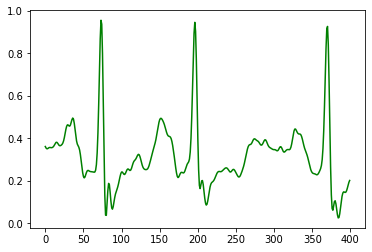

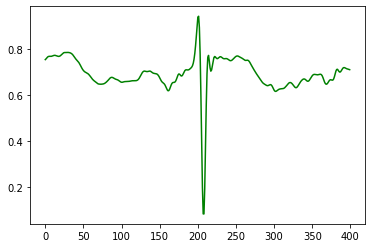

In [67]:
def plot_patch(id):
    fig,ax = plt.subplots()
    y1 = training_patches_df_.loc[id]['first_lead']
    y2 = training_patches_df_.loc[id]['second_lead']
    x = list(range(len(y1)))
    ax.plot(x,y1,color='green')
    plt.show()
    
ids_V = training_patches_df_.index[training_patches_df_['stringLabel'] == 'V'].tolist()
ids_S = training_patches_df_.index[training_patches_df_['stringLabel'] == 'S'].tolist()
ids_N = training_patches_df_.index[training_patches_df_['stringLabel'] == 'N'].tolist()
print(ids_V[:10])
plot_patch(ids_S[10])
plot_patch(ids_N[90])


In [68]:
training_patches_df_.head()

,first_lead,second_lead,stringLabel,label
S097_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S097_1,"[0.9580070239423568, 0.9044837476636258, 0.785...","[0.713288770919864, 0.8458495429006658, 0.9387...",N,"[1.0, 0.0, 0.0]"
S097_2,"[0.7672940776207775, 0.7870035599502193, 0.799...","[0.2168754104759363, 0.22320038213098628, 0.23...",N,"[1.0, 0.0, 0.0]"
S097_3,"[0.7011402691586823, 0.8031266876022192, 0.833...","[0.07939469693321582, 0.15298963418648673, 0.2...",N,"[1.0, 0.0, 0.0]"
S097_4,"[0.03814290879468285, 0.0, 0.0898866660918213,...","[0.5283502311750367, 0.31129590244398064, 0.14...",N,"[1.0, 0.0, 0.0]"


How many training indx: 183323
Balancing training...
pre drop: 198588
post drop:23825
43609
1091
1048
Balancing validation


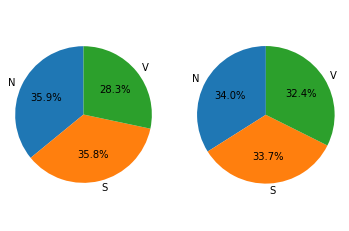

In [69]:
#Balance training and validation sets 
training_patches_df = training_patches_df_.copy(deep=True)
validation_patches_df = validation_patches_df_.copy(deep=True)

training_df.head()

training_patients = training_df['sigId']
validation_patients = validation_df['sigId']

# calculate percentage of heartbeats to drop 

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v)
perc_to_drop_train = to_drop/(num_n)

num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v)
perc_to_drop_valid = to_drop/(num_n)

train_indexes = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist()
valid_indexes = validation_patches_df.index[validation_patches_df['stringLabel'] == 'N'].tolist()

print(f"How many training indx: {len(train_indexes)}")

train_to_drop = list()
valid_to_drop = list()
lengths = list()
dict_train = {}
valid_train = {}

print("Balancing training...")

for p in training_patients:
    dict_train[p] = list()

for hb in train_indexes:
    dict_train[hb.split('_')[0]].append(hb)

for p in dict_train:
   random.shuffle(dict_train[p])

for k in dict_train:
    train_to_drop += dict_train[k][:int(len(dict_train[k]) * perc_to_drop_train)]

print(f"pre drop: {len(training_patches_df.index)}")
training_patches_df = training_patches_df.drop(train_to_drop)
print(f"post drop:{len(training_patches_df.index)}")
print(num_n)
print(num_s)
print(num_v)
print("Balancing validation")

for p in validation_patients:
    valid_train[p] = list()
    
for hb in valid_indexes:
    valid_train[hb.split('_')[0]].append(hb)

for p in valid_train:
    random.shuffle(valid_train[p])

for k in valid_train:
    valid_to_drop += valid_train[k][:int(perc_to_drop_valid * len(valid_train[k]))]

validation_balanced_patches_df = validation_patches_df.drop(valid_to_drop)


training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()


In [70]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y

In [71]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_balanced_patches_df)
x_test,y_test = create_input(validation_patches_df)

100%|█████████████████████████████████████████████████████████████████████████| 45748/45748 [00:03<00:00, 14675.33it/s]


In [ ]:
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight

batch_size = 128
input_shape = x_train[0].shape

def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(N=10, custom_loss = None): 
    ecg_input = keras.layers.Input(shape=input_shape, name='ecg_signal') 
    ResNet = keras.layers.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = keras.layers.GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    #Not necessary?
    #ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = keras.Model(inputs=[ecg_input],outputs=ResNet)
    return model

nn= resnet()

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=True,

)

es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)
pl= keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',patience=4,factor=0.1,verbose=1,min_lr=1e-11)
callbacks = [es]

nn= resnet()



learning_rate = 1e-6

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.75)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    name="Adam",
)


nn.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['Precision','accuracy'],
)

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=callbacks,
    #class_weight = d_class_weights
).history

#validation_data=(X_val_filt, y_val),

Epoch 1/100
186/186 [==============================] - 158s 776ms/step - loss: 1.9117 - precision: 0.3606 - accuracy: 0.3587 - val_loss: 1.1591 - val_precision: 0.4831 - val_accuracy: 0.3362
Epoch 2/100
127/186 [===================>..........] - ETA: 44s - loss: 1.3607 - precision: 0.4326 - accuracy: 0.4189

In [ ]:


# take also old samples to assess performances 
def plot_confusion_matrix(y_true, y_pred,normalized):
    """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
    """
    con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
    if (normalized):
      con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
      con_mat_df = pd.DataFrame(con_mat_norm,
                      index = classes, 
                      columns = classes)
    else:
        con_mat_df = pd.DataFrame(con_mat,
                      index = classes, 
                      columns = classes)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return con_mat


print("Making predictions ...",end="\r")

y_pred= nn.predict(x_test)

y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_test, axis=1)

conf = plot_confusion_matrix(y_val_classes, y_pred,0)
conf = plot_confusion_matrix(y_val_classes, y_pred,1)